![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/39cb56feae6766464d39dd2349480b97099d2535/imgs/LightAutoML_logo_big.png)

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/sb-ai-lab/LightAutoML). 

## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [ ]:
!pip install -U --ignore-installed lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS and HTTP requests etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [5]:
# Standard python libraries
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

### 0.2. Constants

Here we setup some parameters to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [6]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 10*3600
TARGET_NAME = 'hospital_death'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [7]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [8]:
train_data = pd.read_csv('../input/patient-survival-prediction/train.csv')
print(train_data.shape)
train_data.head()

(64199, 86)


,Unnamed: 0,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,82707,36751,69039,158,66.0,35.693127,0,Caucasian,F,152.4,...,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
1,80002,68336,127397,47,48.0,18.966902,0,African American,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,1
2,54817,71682,77670,27,76.0,19.278960,0,Caucasian,M,173.0,...,0.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,NaN,0
3,44799,114267,19566,100,43.0,45.617284,0,Caucasian,M,180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Genitourinary,Renal/Genitourinary,NaN,0
4,50277,128055,104990,189,86.0,26.756678,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,1


In [9]:
test_data = pd.read_csv('../input/patient-survival-prediction/test.csv')
print(test_data.shape)
test_data.head()

(27514, 85)


,Unnamed: 0,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83
0,68842,21017,112951,166,57.0,24.161722,1,Caucasian,M,193.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN
1,60574,64708,17307,39,NaN,21.830956,0,Caucasian,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN
2,16041,64871,123759,116,72.0,24.332277,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Musculoskeletal/Skin,Undefined Diagnoses,NaN
3,42932,124400,47970,100,52.0,27.625362,0,Caucasian,F,162.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN
4,90063,32760,24104,2,31.0,39.869524,1,Caucasian,F,152.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Undefined diagnoses,NaN


In [10]:
sub = pd.read_csv('../input/patient-survival-prediction/sample_submission.csv')
print(sub.shape)
sub.head()

(27514, 2)


,patient_id,hospital_death
0,112951,0
1,17307,1
2,123759,0
3,47970,1
4,24104,0


### 0.5. EDA

In [11]:
train_data.drop(columns = ['Unnamed: 0', 'Unnamed: 83'], inplace = True)
test_data.drop(columns = ['Unnamed: 0', 'Unnamed: 83'], inplace = True)

In [12]:
train_ids = set(train_data['patient_id'].values)
test_ids = set(test_data['patient_id'].values)
len(train_ids.intersection(test_ids))

0

In [13]:
train_ids = set(train_data['encounter_id'].values)
test_ids = set(test_data['encounter_id'].values)
len(train_ids.intersection(test_ids))

0

It is important to note that missing values (NaN and other) in the data should be left as is, unless the reason for their presence or their specific meaning are known. Otherwise, AutoML model will perceive the filled NaNs as a true pattern between the data and the target variable, without knowledge and assumptions about missing values, which can negatively affect the model quality. LighAutoML can deal with missing values and outliers automatically.

## 1. Task definition

### 1.1. Task type

First we need to create ```Task``` object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation).

The following task types are available:

- ```'binary'``` - for binary classification.

- ```'reg’``` - for regression.

- ```‘multiclass’``` - for multiclass classification.

- ```'multi:reg``` - for multiple regression.

- ```'multilabel'``` - for multi-label classification.

In this example we will consider a binary classification:

In [14]:
task = Task('binary')

Note that only logloss loss is available for binary task and it is the default loss. Default metric for binary classification is ROC-AUC. See more info about available and default losses and metrics [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task). 

**Depending on the task, you can and shold choose exactly those metrics and losses that you want and need to optimize.**

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. LightAutoML can automatically define types and roles of data columns, but it is possible to specify it directly through the dictionary parameter ```roles``` when training AutoML model (see next section "AutoML training"). Specific roles can be specified using a string with the name (any role can be set like this).  So the key in dictionary must be the name of the role, the value must be a list of the names of the corresponding columns in dataset. The **only role you must setup is** ```'target'``` **role** (that is column with target variable obviously), everything else (```'drop', 'numeric', 'categorical', 'group', 'weights'``` etc) is up to user:

In [15]:
roles = {
    'target': TARGET_NAME,
    'drop': ['patient_id', 'encounter_id']
}

You can also optionally specify the following roles:

- ```'numeric'``` - numerical feature

- ```'category'``` - categorical feature

- ```'text'``` - text data

- ```'datetime'``` - features with date and time 

- ```'date'``` - features with date only

- ```'group'``` - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

- ```'drop'``` - features to drop, they will not be used in model building

- ```'weights'``` - object weights for the loss and metric

- ```'path'``` - image file paths (for CV tasks)

- ```'treatment'``` - object group in uplift modelling tasks: treatment or control

Note that role name can be written in any case. Also it is possible to pass individual objects of role classes with specific arguments instead of strings with role names for specific tasks and more optimal pipeline construction ([more details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py)).

For example, to set the date role, you can use the ```DatetimeRole``` class. 

In [16]:
# from lightautoml.dataset.roles import DatetimeRole

Different seasonality can be extracted from the data through the ```seasonality``` parameter: years (```'y'```), months (```'m'```), days (```'d'```), weekdays (```'wd'```), hours (```'hour'```), minutes (```'min'```), seconds (```'sec'```), milliseconds (```'ms'```), nanoseconds (```'ns'```). This features will be considered as categorical. Another important parameter is ```base_date```. It allows to specify the base date and convert the feature to the distances to this date (set to ```False``` by default). Also for all roles classes there is a ```force_input``` parameter, and if it is ```True```, then the corresponding features will pass all further feature selections and won't be excluded (equals ```False``` by default). Also it is always possible to specify data type for all roles using ```dtype``` argument.

Here is an example of such a role assignment through a class object for date feature (but there is no such feature in the considered dataset):

In [17]:
# roles = {
#     DatetimeRole(base_date=False, seasonality=('d', 'wd', 'hour')): 'date_time'
# }

Any role can be set through a class object. Information about specific parameters of specific roles and other datailed information can be found [here](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py).

### 1.3. LightAutoML model creation - TabularAutoML preset

Next we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure in just several lines. 

In general, the whole AutoML model consists of multiple levels, which can contain several pipelines with their own set of data processing methods and ML models. The outputs of one level are the inputs of the next, and on the last level predictions of previous level models are combined with blending procedure. All this can be combined into a model using the ```AutoML``` class and its various descendants (like ```TabularAutoML```).

Let's look at how the LightAutoML model is arranged and what it consists in general.

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_laml_big.png)

#### 1.3.1 Reader object

First the task and data go into ```Reader``` object. It analyzes the data and extracts various valuable information from them. Also it can detect and remove useless features, conduct feature selection, determine types and roles etc. Let's look at this steps in more detail.

**Role and types guessing**

Roles can be specified as a string or a specific class object, or defined automatically. For ```TabularAutoML``` preset ```'numeric'```, ```'datetime'``` and ```'category'``` roles can be automatically defined. There are two ways of role defining. **First** is very simple: check if the value can be converted to a date (```'datetime'```), otherwise check if it can be converted to a number (```'numeric'```), otherwise declare it a category (```'categorical'```). But this method may not work well on large data or when encoding categories with integers. The **second** method is based on statistics: the distributions of numerical features are considered, and how similar they are to the distributions of real or categorical value. Also different ways of feature encoding (as a number or as a category) are compared and based on normalized Gini index it is decided which encoding is better. For this case a set of specific rules is created, and if at least one of them is fullfilled, then the feature will be assigned to numerical, otherwise to categorical. This check can be enabled or disabled using the ```advanced_roles``` parameter. 

If roles are explicitly specified, automatic definition won't be applied to the specified dataset columns. In the case of specifying a role as an object of a certain class, through its arguments, it is possible to set the processing parameters in more detail.
 
**Feature selection**

In general, the AutoML pipeline uses pre-selection, generation and post-selection of features. ```TabularAutoML``` has no post-selection stage. There are three feature selection methods: its absence, using features importances and more strict selection (forward selection). The GBM model is used to evaluate features importances. Importances can be calculated in 2 ways: based on splits (how many times a split was made for each feature in the entire ensemble) or using permutation feature importances (mixing feature values during validation and assessing quality change in this case). Second method is harder but it requires holdout data. Then features with importance above a certain threshold are selected. Faster and more strict feature selection method is forward selection. Features are sorted in descending order of importance, then in blocks (size of 1 by default) a model is built based on selected features, and its quality is measured. Then the next block of features is added, and they are saved if the quality has improved with them, and so on.  

Also LightAutoML can merge some columns if it is adequate and leads to an improvement in the model quality (for example, an intersection between categorical variables). Different columns join options are considered, the best one is chosen by the normalized Gini index. 

#### 1.3.2 Machine learning pipelines architecture and training

As a result, after analyzing and processing the data, the ```Reader``` object forms and returns a ```LAMA Dataset```. It contains the original data and markup with metainformation. In this dataset it is possible to see the roles defined by the ```Reader``` object, selected features etc. Then ML pipelines are trained on this data. 

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_ml_pipeline.png)

Each such pipeline is one or more machine learning algorithms that share one post-processing block and one validation scheme. Several such pipelines can be trained in parallel on one dataset, and they form a level. Number of levels can be unlimited as possible. List of all levels of AutoML pipeline is available via ```.levels``` attribute of ```AutoML``` instance. Level predictions can be inputs to other models or ML pipelines (i. e. stacking scheme). As inputs for subsequent levels, it is possible to use the original data by setting ```skip_conn``` argument in ```True``` when initializing preset instance. At the last level, if there are several pipelines, blending is used to build a prediction. 

Different types of features are processed depending on the models. Numerical features are processed for linear model preprocessing: standardization, replacing missing values with median, discretization, log odds (if feature is probability - output of previous level). Categories are processed using label encoding (by default), one hot encoding, ordinal encoding, frequency encoding, out of fold target encoding. 

The following algorithms are available in the LightAutoML: linear regression with L2 regularization, LightGBM, CatBoost, random forest. 

By default KFold cross-validation is used during training at all levels (for hyperparameter optimization and building out-of-fold prediction during training), and for each algorithm a separate model is built for each validation fold, and their predictions are averaged. So the predictions at each level and the resulting prediction during training are out-of-fold predictions. But it is also possible to just pass a holdout data for validation or use custom cross-validation schemes, setting ```cv_iter``` iterator returning the indices of the objects for validation. LightAutoML has ready-made iterators, for example, ```TimeSeriesIterator``` for time series split. To further reduce the effect of overfitting, it is possible to use nested cross-validation (```nested_cv``` parameter), but it is not used by default. 

Prediction on new data is the averaging of models over all folds from validation and blending. 

Hyperparameter tuning of machine learning algorithms can be performed during training (early stopping by the number of trees in gradient boosting or the number of training epochs of neural networks etc), based on expert rules (according to data characteristics and empirical recommendations, so-called expert parameters), by the sequential model-based optimization (SMBO, bayesian optimization: Optuna with TPESampler) or by grid search. LightGBM and CatBoost can be used with parameter tuning or with expert parameters, with no tuning. For linear regression parameters are always tuned using warm start model training technique. 

At the last level blending is used to build a prediction. There are three available blending methods: choosing the best model based on a given metric (other models are just discarded), simple averaging of all models, or weighted averaging (weights are selected using coordinate descent algorithm with optimization of a given metric). ```TabularAutoML ``` uses the latter strategy by default. It is worth noting that, unlike stacking, blending can exclude models from composition. 

#### 1.3.3 Timing

When creating AutoML object, a certain time limit is set, and it schedules a list of tasks that it can complete during this time, and it will initially allocate approximately equal time for each task. In the process of solving objectives, it understands how to adjust the time allocated to different subtasks. If AutoML finished working earlier than set timeout, it means that it completed the entire list of tasks. If AutoML worked to the limit and turned off, then most likely it sacrificed something, for example, reduced the number of algorithms for training, realized that it would not have time to train the next one, or it might not calculate the full cross-validation cycle for one of the models (then on folds, where the model has not trained, the predictiuons will be NaN, and the model related to this fold will not participate in the final averaging). The resulting quality is evaluated at the blending stage, and if necessary and possible, the composition will be corrected. 

If you do not set the time for AutoML during initialization, then by default it will be equal to a very large number, that is, sooner or later AutoML will complete all tasks. 

#### 1.3.4 LightAutoML model creation

So the entire AutoML pipeline can be composed from various parts by user (see [custom pipeline tutorial](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_6_custom_pipeline.ipynb)), but it is possible to use presets - in a certain sense, fixed strategies for dynamic pipeline building. 

Here is a default AutoML pipeline for binary classification and regression tasks (```TabularAutoML``` preset):

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_blackbox_pipeline.png)

Another example:

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_1_pipeline.png)

Let's discuss some of the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for ```Reader``` object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - general parameters dictionary, in which it is possible to specify a list of algorithms used (```'use_algos'```), nested CV using (```'nested_cv'```) etc.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [18]:
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    tuning_params = {'max_tuning_time': 900},
    reader_params = {'n_jobs': N_THREADS}
)

## 2. AutoML training

To run autoML training use ```fit_predict``` method. 

Main arguments:

- `train_data` - dataset to train.
- `roles` - column roles dict.
- `verbose` - controls the verbosity: the higher, the more messages:
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [19]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1)

[11:51:12] Start automl utilizator with listed constraints:
[11:51:12] - time: 36000.00 seconds
[11:51:12] - CPU: 4 cores
[11:51:12] - memory: 16 GB

[11:51:12] If one preset completes earlier, next preset configuration will be started

[11:51:12] ==================================================
[11:51:12] Start 0 automl preset configuration:
[11:51:12] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[11:51:12] Stdout logging level is INFO.
[11:51:12] Task: binary

[11:51:12] Start automl preset with listed constraints:
[11:51:12] - time: 36000.00 seconds
[11:51:12] - CPU: 4 cores
[11:51:12] - memory: 16 GB

[11:51:12] Train data shape: (64199, 84)

[11:51:23] Layer 1 train process start. Time left 35989.21 secs
[11:51:27] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:51:50] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8835597059379418
[11:51:50] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and pr

## 3. Prediction for test data

In [20]:
%%time

test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[0.00461413],
       [0.06340717],
       [0.03322357],
       ...,
       [0.08520202],
       [0.02180826],
       [0.0057804 ]], dtype=float32)
Shape = (27514, 1)
CPU times: user 2min 20s, sys: 292 ms, total: 2min 20s
Wall time: 45 s


In [21]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

OOF score: 0.8970754870144355


## 4. Model analysis

### 4.1. Model structure

You can obtain the description of the resulting pipeline:

In [22]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.47748 * 3 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.05597 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.42481 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.12477 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.14826 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.24619 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #1.
		Final prediction for new objects (level 0) = 
			 0.10415 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.24733 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.23854 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.14866 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.26132 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #2.
		Final prediction for new objects (le

### 4.2 Feature importances calculation 


For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). There is no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: user 378 ms, sys: 226 ms, total: 604 ms
Wall time: 315 ms


<AxesSubplot:xlabel='Feature'>

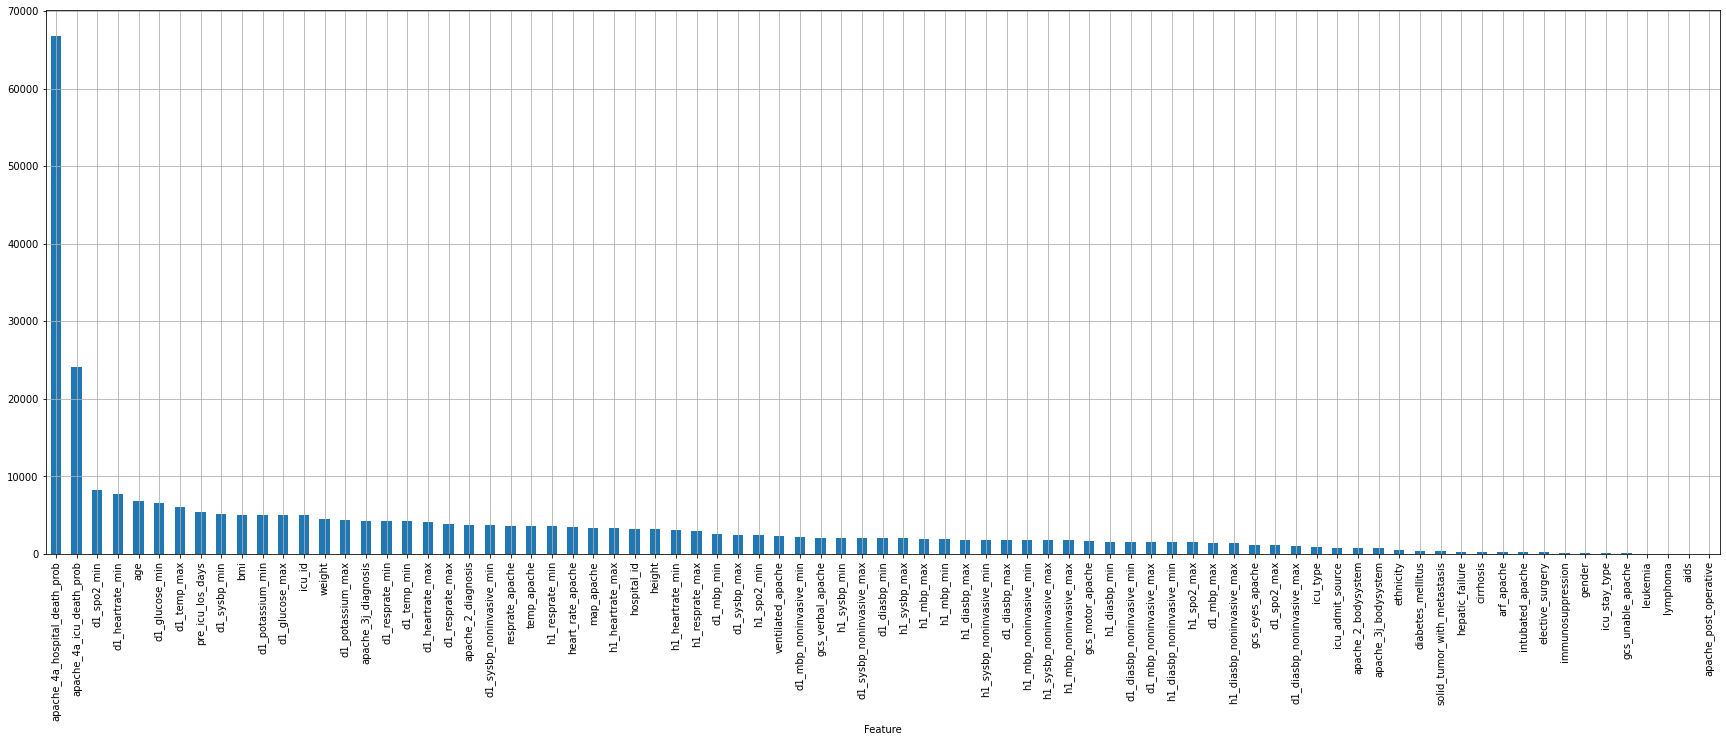

In [23]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

## 5. Create submission

In [24]:
sub[TARGET_NAME] = test_pred.data[:, 0]

In [25]:
sub

,patient_id,hospital_death
0,112951,0.004614
1,17307,0.063407
2,123759,0.033224
3,47970,0.004013
4,24104,0.008031
...,...,...
27509,123967,0.043801
27510,47734,0.012334
27511,12367,0.085202
27512,100290,0.021808


In [26]:
sub.to_csv('LightAutoML_utilized_submission.csv', index = False)